# Parsing Lidar Data

Importing necessary libraries

In [2]:
import pandas as pd
from io import  StringIO
import seaborn as sns
import matplotlib.pyplot as plt

Reading lidar log file to panda dataframe

In [28]:
with open("data/lidar_log_grilstad_22.09.22_10_00_13_00.txt") as f:
    text_lidar_data = f.read().replace('\\"', "").replace("\"", "").replace("  ", " ")
#print(text_lidar_data)
raw_lidar_data = pd.read_csv(
    StringIO(text_lidar_data),
    sep=" ",
    engine="python",
    names=[i for i in range(49)],
    quoting=3,
    on_bad_lines="warn",
    header=None,
)
raw_lidar_data.to_csv("test.csv")

Parsing table with the following structure

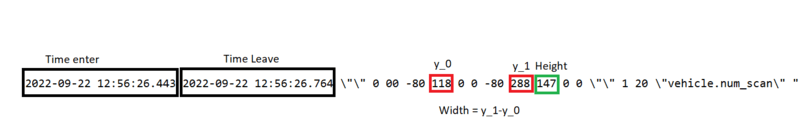

In [30]:
from datetime import timedelta


lidar_data = raw_lidar_data.filter([5, 27, 28, 29, 30, 34, 38, 39])
lidar_data.rename(
    columns=(
        {
            27: "time_enter_date",
            28: "time_enter_time",
            29: "time_leave_date",
            30: "time_leave_time",
            34: "y0",
            38: "y1",
            39: "height",
        }
    ),
    inplace=True,
)
# print(lidar_data)
lidar_data["datetime_enter"] = pd.to_datetime(
    lidar_data["time_enter_date"] + " " + lidar_data["time_enter_time"]
)
lidar_data["datetime_leave"] = pd.to_datetime(
    lidar_data["time_leave_date"] + " " + lidar_data["time_leave_time"]
)
lidar_data.drop(
    ["time_enter_date", "time_enter_time", "time_leave_date", "time_leave_time"],
    axis=1,
    inplace=True,
)
lidar_data["width"] = lidar_data["y1"] - lidar_data["y0"]
lidar_data = lidar_data[lidar_data[5] == "mldcs.VehicleDetector[0]"]
lidar_data["duration"] = lidar_data["datetime_leave"] - lidar_data["datetime_enter"]
lidar_data["area"] = lidar_data["width"] * lidar_data["height"]
lidar_data["duration"] = lidar_data.duration.dt.total_seconds()
lidar_data


                               5 time_enter_date time_enter_time  \
0       mldcs.VehicleDetector[0]      2022-09-22    10:00:01.709   
1     mldcs.VehicleClassifier[0]      2022-09-22    10:00:01.709   
2       mldcs.VehicleDetector[0]      2022-09-22    10:00:11.324   
3     mldcs.VehicleClassifier[0]      2022-09-22    10:00:11.324   
4       mldcs.VehicleDetector[0]      2022-09-22    10:00:48.591   
...                          ...             ...             ...   
1283  mldcs.VehicleClassifier[0]      2022-09-22    12:59:35.330   
1284    mldcs.VehicleDetector[0]      2022-09-22    12:59:37.770   
1285  mldcs.VehicleClassifier[0]      2022-09-22    12:59:37.770   
1286    mldcs.VehicleDetector[0]      2022-09-22    12:59:45.385   
1287  mldcs.VehicleClassifier[0]      2022-09-22    12:59:45.385   

     time_leave_date time_leave_time   y0   y1  height  
0         2022-09-22    10:00:02.164  120  283     155  
1         2022-09-22    10:00:02.164  120  283     155  
2         20

,5,y0,y1,height,datetime_enter,datetime_leave,width,duration,area
0,mldcs.VehicleDetector[0],120,283,155,2022-09-22 10:00:01.709,2022-09-22 10:00:02.164,163,0.455,25265
2,mldcs.VehicleDetector[0],168,336,159,2022-09-22 10:00:11.324,2022-09-22 10:00:11.604,168,0.280,26712
4,mldcs.VehicleDetector[0],118,290,199,2022-09-22 10:00:48.591,2022-09-22 10:00:49.006,172,0.415,34228
6,mldcs.VehicleDetector[0],350,500,168,2022-09-22 10:01:00.752,2022-09-22 10:01:01.206,150,0.454,25200
8,mldcs.VehicleDetector[0],120,279,161,2022-09-22 10:01:15.099,2022-09-22 10:01:15.419,159,0.320,25599
...,...,...,...,...,...,...,...,...,...
1278,mldcs.VehicleDetector[0],65,314,341,2022-09-22 12:59:27.864,2022-09-22 12:59:29.957,249,2.093,84909
1280,mldcs.VehicleDetector[0],137,302,161,2022-09-22 12:59:32.650,2022-09-22 12:59:33.010,165,0.360,26565
1282,mldcs.VehicleDetector[0],134,308,199,2022-09-22 12:59:35.330,2022-09-22 12:59:35.757,174,0.427,34626
1284,mldcs.VehicleDetector[0],89,277,254,2022-09-22 12:59:37.770,2022-09-22 12:59:38.304,188,0.534,47752


<AxesSubplot: xlabel='height', ylabel='Count'>

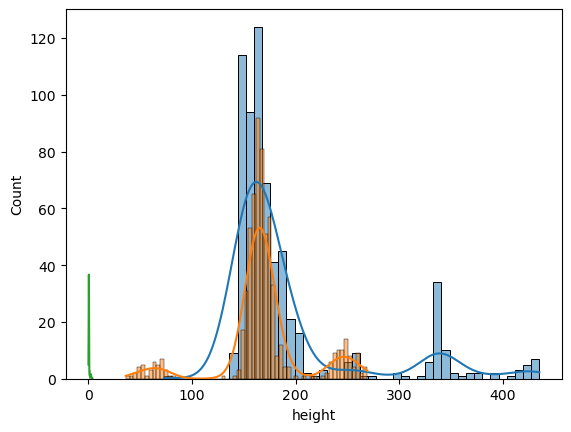

In [10]:
sns.histplot(lidar_data['height'], kde=True)
sns.histplot(lidar_data['width'], kde=True)
sns.histplot(lidar_data['duration'], kde=True)

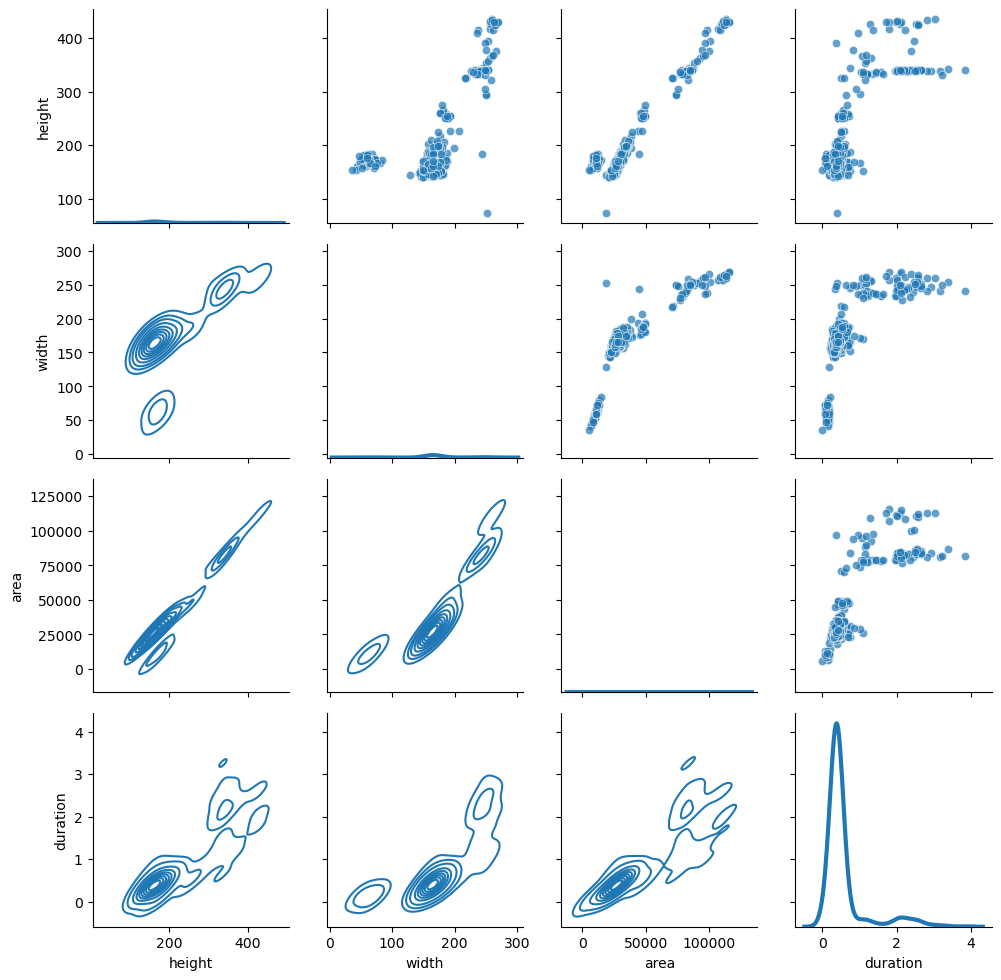

In [11]:
g = sns.PairGrid(lidar_data, vars=['height', 'width','area', 'duration'])
g.map_upper(sns.scatterplot, alpha=0.7)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [12]:
lidar_data.loc[lidar_data["width"] < 100, "type"] = "Small"
lidar_data.loc[(lidar_data["width"] >= 100) & (lidar_data["width"] <= 200), "type"] = "Medium"
lidar_data.loc[lidar_data["width"] > 200, "type"] = "Big"

Here it seems like the durations for vehicles labeled Small and Medium are correct, but the vehicles labeled Big seem weird. This might be because it struggles to see how long the trailer is.

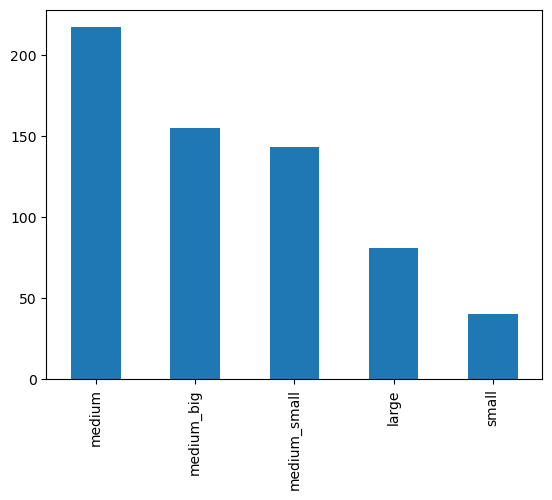

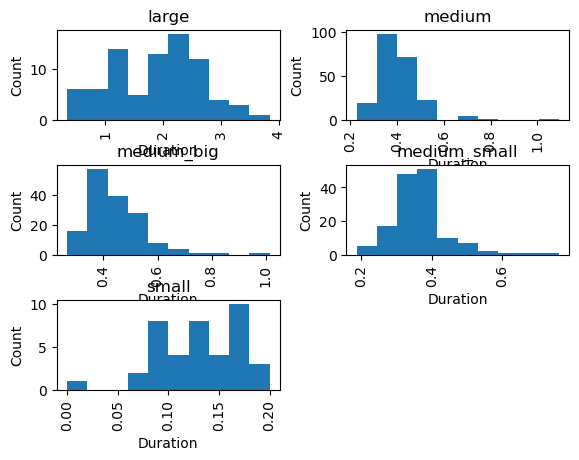

In [2]:
lidar_data["class_2"].value_counts().plot(kind="bar")
axs = lidar_data.hist(column=["duration"], by="class_2")
for ax in axs.flatten():
    ax.set_xlabel("Duration")
    ax.set_ylabel("Count")

In [3]:
from src import classify_lidar, parse_lidar
parsed_lidar = parse_lidar("../data/lidar_log_grilstad_27.09.22_12_00_17_00.txt")
classified_lidar = classify_lidar(parsed_lidar)
classified_lidar

,y0,y1,height,width,front_area,datetime_enter,datetime_leave,duration,class_1,class_2
0,341,501,170,160,27200,2022-09-27 12:00:01.477,2022-09-27 12:00:01.931,0.454,medium,medium_small
1,380,546,164,166,27224,2022-09-27 12:00:40.412,2022-09-27 12:00:41.772,1.360,medium,medium
2,345,527,194,182,35308,2022-09-27 12:00:53.079,2022-09-27 12:00:53.546,0.467,medium,medium_big
3,356,529,153,173,26469,2022-09-27 12:00:55.319,2022-09-27 12:00:55.839,0.520,medium,medium_big
4,103,258,168,155,26040,2022-09-27 12:01:17.213,2022-09-27 12:01:17.600,0.387,medium,medium_small
...,...,...,...,...,...,...,...,...,...,...
1669,390,550,156,160,24960,2022-09-27 16:59:35.267,2022-09-27 16:59:35.668,0.401,medium,medium_small
1670,120,265,160,145,23200,2022-09-27 16:59:35.895,2022-09-27 16:59:36.215,0.320,medium,medium_small
1671,81,255,157,174,27318,2022-09-27 16:59:39.348,2022-09-27 16:59:39.721,0.373,medium,medium_big
1672,112,275,183,163,29829,2022-09-27 16:59:44.681,2022-09-27 16:59:45.041,0.360,medium,medium
